# Set Up



In [ ]:
!pip install scikeras

# read in data
import gzip
import json
import pandas as pd
import sys
import pathlib

# check balance of dataset
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import linregress
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# rebalance
from imblearn.over_sampling import SMOTE

# Rule-based algorithms and machine learning models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# Utility imports
import joblib
import sklearn.metrics as metrics  # For evaluation metrics
from sklearn.metrics import precision_recall_curve  # Precision-recall curve function
from sklearn.model_selection import cross_val_score  # Cross-validation

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import randint, uniform
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import initializers
from sklearn.metrics import make_scorer, f1_score

In [ ]:
# Download labelled data
!gdown 'https://drive.google.com/uc?id=1dsiGWXSbu7KMfOK_kH7XjADmLkgzpVfb'

# Download dataset.json.gz
!gdown 'https://drive.google.com/uc?id=1plz7kDOHdG5kp71goZv9wdLp10ULBE-a'

# Download dataset retrieved from research gateway
!gdown 'https://drive.google.com/uc?id=19IvRhnKRw-ql1O7WPP_nHLiQUdZ7z2Qv'

Downloading...
From: https://drive.google.com/uc?id=1dsiGWXSbu7KMfOK_kH7XjADmLkgzpVfb
To: /content/data.info.labelled
100% 4.70M/4.70M [00:00<00:00, 155MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1plz7kDOHdG5kp71goZv9wdLp10ULBE-a
From (redirected): https://drive.google.com/uc?id=1plz7kDOHdG5kp71goZv9wdLp10ULBE-a&confirm=t&uuid=b2d1f10c-3d8a-4384-bea4-d4e66aaf219c
To: /content/dataset0.json.gz
100% 180M/180M [00:04<00:00, 44.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=19IvRhnKRw-ql1O7WPP_nHLiQUdZ7z2Qv
From (redirected): https://drive.google.com/uc?id=19IvRhnKRw-ql1O7WPP_nHLiQUdZ7z2Qv&confirm=t&uuid=d98bf12d-e86c-44d8-8b93-0f8557b9f3cd
To: /content/df.csv
100% 912M/912M [00:14<00:00, 61.5MB/s]


# Data Exploration

In [ ]:
# Read in data
data_json = pd.read_csv('df.csv', sep=';')
data_labels = pd.read_csv('data.info.labelled', sep=',')

In [ ]:
data_json.head()

,Transcript_ID,Position,Sequence,Dwelling_Time_1,SD_1,Mean_1,Dwelling_Time_2,SD_2,Mean_2,Dwelling_Time_3,SD_3,Mean_3
0,ENST00000000233,244,AAGACCA,0.00299,2.06,125.0,0.01770,10.40,122.0,0.00930,10.90,84.1
1,ENST00000000233,244,AAGACCA,0.00631,2.53,125.0,0.00844,4.67,126.0,0.01030,6.30,80.9
2,ENST00000000233,244,AAGACCA,0.00465,3.92,109.0,0.01360,12.00,124.0,0.00498,2.13,79.6
3,ENST00000000233,244,AAGACCA,0.00398,2.06,125.0,0.00830,5.01,130.0,0.00498,3.78,80.4
4,ENST00000000233,244,AAGACCA,0.00664,2.92,120.0,0.00266,3.94,129.0,0.01300,7.15,82.2


In [ ]:
data_labels.head()

,gene_id,transcript_id,transcript_position,label
0,ENSG00000004059,ENST00000000233,244,0
1,ENSG00000004059,ENST00000000233,261,0
2,ENSG00000004059,ENST00000000233,316,0
3,ENSG00000004059,ENST00000000233,332,0
4,ENSG00000004059,ENST00000000233,368,0


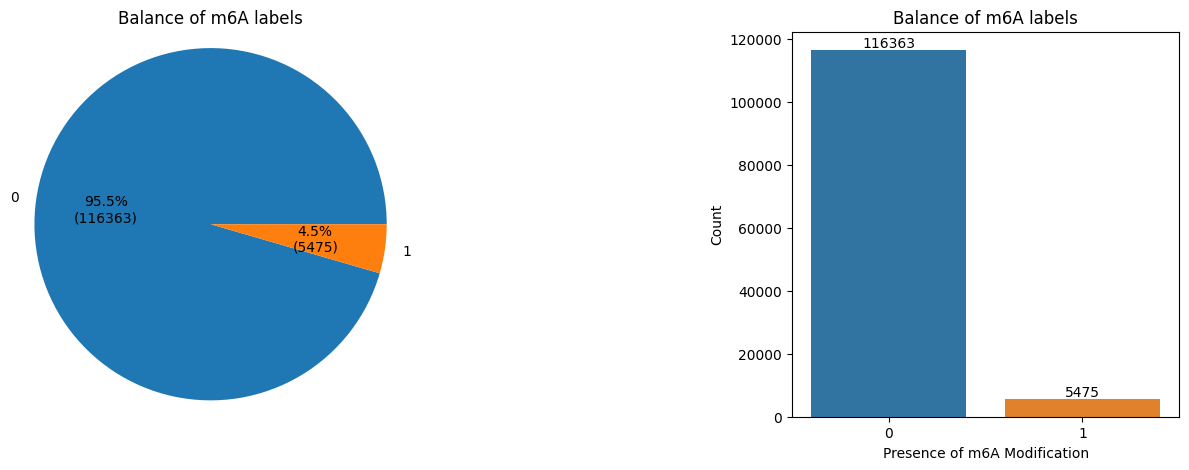

In [ ]:
def visualise():
    # Visualisation of dataset's split for different types of tumors
    data_balance = data_labels['label'].value_counts()

    def custom_autopct(pct):
        total = sum(data_balance)
        val = int(round(pct * total / 100.0))
        return "{:.1f}%\n({:d})".format(pct, val)

    # Create subplots with 1 row and 2 columns, with space between the plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Pie chart for data balance
    axes[0].pie(data_balance, labels=data_balance.index, autopct=custom_autopct, colors=["#1f77b4", "#ff7f0e"])
    axes[0].set_title("Balance of m6A labels")
    axes[0].axis("equal")

    # Check dataset balance
    colors = ["#1f77b4", "#ff7f0e"]
    bar_plot = sns.countplot(data=data_labels, x="label", hue="label", palette=colors, ax=axes[1], legend=False)
    axes[1].set_xlabel('Presence of m6A Modification') # 0: position is unmodified, 1: position has m6A modification
    axes[1].set_ylabel('Count')
    axes[1].set_title('Balance of m6A labels')

    # Add count numbers for each bar in the count plot
    for p in bar_plot.patches:
        bar_plot.annotate(format(p.get_height(), '.0f'),
                          (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha='center', va='center',
                          xytext=(0, 5),
                          textcoords='offset points')

    plt.subplots_adjust(wspace=1)
    plt.show()

# Run to visualise the dataset
visualise()

# Feature Engineering

In [ ]:
columns_to_compare = ['Dwelling_Time', 'Mean', 'SD']

for col in columns_to_compare:
    data_json[f'Difference_{col}_1_2'] = data_json[f'{col}_2'] - data_json[f'{col}_1']
    data_json[f'Difference_{col}_2_3'] = data_json[f'{col}_2'] - data_json[f'{col}_3']

data_json

,Transcript_ID,Position,Sequence,Dwelling_Time_1,SD_1,Mean_1,Dwelling_Time_2,SD_2,Mean_2,Dwelling_Time_3,SD_3,Mean_3,Difference_Dwelling_Time_1_2,Difference_Dwelling_Time_2_3,Difference_Mean_1_2,Difference_Mean_2_3,Difference_SD_1_2,Difference_SD_2_3
0,ENST00000000233,244,AAGACCA,0.00299,2.06,125.0,0.01770,10.40,122.0,0.00930,10.90,84.1,0.01471,0.00840,-3.0,37.9,8.34,-0.50
1,ENST00000000233,244,AAGACCA,0.00631,2.53,125.0,0.00844,4.67,126.0,0.01030,6.30,80.9,0.00213,-0.00186,1.0,45.1,2.14,-1.63
2,ENST00000000233,244,AAGACCA,0.00465,3.92,109.0,0.01360,12.00,124.0,0.00498,2.13,79.6,0.00895,0.00862,15.0,44.4,8.08,9.87
3,ENST00000000233,244,AAGACCA,0.00398,2.06,125.0,0.00830,5.01,130.0,0.00498,3.78,80.4,0.00432,0.00332,5.0,49.6,2.95,1.23
4,ENST00000000233,244,AAGACCA,0.00664,2.92,120.0,0.00266,3.94,129.0,0.01300,7.15,82.2,-0.00398,-0.01034,9.0,46.8,1.02,-3.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11027101,ENST00000641834,1693,TTGACAT,0.00418,7.49,108.0,0.00564,10.20,116.0,0.01000,2.01,76.4,0.00146,-0.00436,8.0,39.6,2.71,8.19
11027102,ENST00000641834,1693,TTGACAT,0.00664,1.91,109.0,0.00598,12.30,110.0,0.01760,2.61,74.6,-0.00066,-0.01162,1.0,35.4,10.39,9.69
11027103,ENST00000641834,1693,TTGACAT,0.00721,4.58,105.0,0.00398,6.58,113.0,0.00316,2.28,85.3,-0.00323,0.00082,8.0,27.7,2.00,4.30
11027104,ENST00000641834,1693,TTGACAT,0.00266,2.33,109.0,0.00913,10.40,108.0,0.00664,4.44,76.8,0.00647,0.00249,-1.0,31.2,8.07,5.96


In [ ]:
# Define the aggregation function
agg_funcs = ['min', 'max', 'mean', 'median', 'std']

# Aggregate by Transcript_ID, Position, and Sequence
data_json_grouped = data_json.groupby(['Transcript_ID', 'Position', 'Sequence']).agg({
    'Dwelling_Time_1': agg_funcs,
    'SD_1': agg_funcs,
    'Mean_1': agg_funcs,
    'Dwelling_Time_2': agg_funcs,
    'SD_2': agg_funcs,
    'Mean_2': agg_funcs,
    'Dwelling_Time_3': agg_funcs,
    'SD_3': agg_funcs,
    'Mean_3': agg_funcs,
    'Difference_Dwelling_Time_1_2': agg_funcs,
    'Difference_Dwelling_Time_2_3': agg_funcs,
    'Difference_Mean_1_2': agg_funcs,
    'Difference_Mean_2_3': agg_funcs,
    'Difference_SD_1_2': agg_funcs,
    'Difference_SD_2_3': agg_funcs,
})

# Reset the index to bring 'Transcript_ID', 'Position', and 'Sequence' back as columns
data_json_grouped = data_json_grouped.reset_index()

# Rename columns accordingly
data_json_grouped.columns = ['{}_{}'.format(col[0], col[1]) if col[1] != '' else col[0] for col in data_json_grouped.columns]

In [ ]:
data_json_grouped

,Transcript_ID,Position,Sequence,Dwelling_Time_1_min,Dwelling_Time_1_max,Dwelling_Time_1_mean,Dwelling_Time_1_median,Dwelling_Time_1_std,SD_1_min,SD_1_max,...,Difference_SD_1_2_min,Difference_SD_1_2_max,Difference_SD_1_2_mean,Difference_SD_1_2_median,Difference_SD_1_2_std,Difference_SD_2_3_min,Difference_SD_2_3_max,Difference_SD_2_3_mean,Difference_SD_2_3_median,Difference_SD_2_3_std
0,ENST00000000233,244,AAGACCA,0.00199,0.0339,0.008264,0.00697,0.005399,1.770,13.40,...,-4.97,11.84,3.158378,3.100,3.368458,-11.01,14.18,2.995173,2.690,4.595526
1,ENST00000000233,261,CAAACTG,0.00199,0.0222,0.006609,0.00564,0.003599,0.919,17.00,...,-13.94,8.79,0.010110,0.065,2.105865,-11.60,8.21,0.209936,0.315,2.003694
2,ENST00000000233,316,GAAACAG,0.00232,0.0299,0.007570,0.00631,0.004456,1.280,11.60,...,-7.74,4.04,0.702162,0.970,1.655099,-3.63,3.71,1.555557,1.740,1.157738
3,ENST00000000233,332,AGAACAT,0.00232,0.0370,0.010620,0.00902,0.006136,1.220,14.20,...,-12.51,13.94,-3.577150,-3.075,3.050457,-4.98,13.59,0.662680,0.505,1.498928
4,ENST00000000233,368,AGGACAA,0.00199,0.0478,0.010701,0.00896,0.007169,1.150,39.00,...,-30.53,6.91,-0.544747,-0.830,3.031754,-4.21,7.91,1.610051,1.365,2.317262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,ENST00000641834,1348,GGGACAT,0.00232,0.0432,0.009594,0.00817,0.006178,0.924,6.00,...,-2.21,7.64,1.635562,1.230,2.459619,-10.34,7.11,0.924110,0.860,3.086679
121834,ENST00000641834,1429,CTGACAC,0.00232,0.0262,0.008393,0.00618,0.005625,1.770,10.30,...,-4.01,9.02,4.594783,4.520,2.522198,0.89,9.69,5.461159,5.400,2.252558
121835,ENST00000641834,1531,TGGACAC,0.00232,0.0315,0.008161,0.00697,0.005521,1.400,6.77,...,-4.34,6.56,0.841250,0.155,2.275315,-2.28,9.76,2.578125,2.650,2.254478
121836,ENST00000641834,1537,CTGACCA,0.00232,0.0483,0.008044,0.00660,0.007090,1.460,8.48,...,-3.74,8.53,3.361754,2.860,2.616618,-0.56,10.25,4.012105,3.740,2.468316


In [ ]:
# Identify unique bases at each position
def unique_bases_at_positions(sequences):
    transposed = list(zip(*sequences))
    unique_bases_per_position = []

    for position, bases in enumerate(transposed):
        unique_bases = set(bases)
        unique_bases_per_position.append((position + 1, sorted(unique_bases)))  # Store position and sorted unique bases

    return unique_bases_per_position

results = unique_bases_at_positions(data_json_grouped['Sequence'])

# Print the results
for position, bases in results:
    print(f"Position {position}: {bases}")


Position 1: ['A', 'C', 'G', 'T']
Position 2: ['A', 'G', 'T']
Position 3: ['A', 'G']
Position 4: ['A']
Position 5: ['C']
Position 6: ['A', 'C', 'T']
Position 7: ['A', 'C', 'G', 'T']


In [ ]:
dra_ch_motifs = [
    "AAACA", "AAACC", "AAACT",
    "AGACA", "AGACC", "AGACT",
    "GAACA", "GAACC", "GAACT",
    "GGACA", "GGACC", "GGACT",
    "TAACA", "TAACC", "TAACT",
    "TGACA", "TGACC", "TGACT"
]

pos_1_5 = [
    "GAAAC", "AAAAC", "CAAAC", "TAAAC",
    "GAGAC", "AAGAC", "CAGAC", "TAGAC",
    "GGAAC", "AGAAC", "CGAAC", "TGAAC",
    "GGGAC", "AGGAC", "CGGAC", "TGGAC",
    "GTAAC", "ATAAC", "CTAAC", "TTAAC",
    "GTGAC", "ATGAC", "CTGAC", "TTGAC"
]

pos_3_7 = [
    "AACAG", "AACAA", "AACAC", "AACAT",
    "AACCG", "AACCA", "AACCC", "AACCT",
    "AACTG", "AACTA", "AACTC", "AACTT",
    "GACAG", "GACAA", "GACAC", "GACAT",
    "GACCG", "GACCA", "GACCC", "GACCT",
    "GACTG", "GACTA", "GACTC", "GACTT",
]

# Extract 5-mer from the 7-mer sequences
data_json_grouped['Front_5mer'] = data_json_grouped['Sequence'].str[0:5]  # Position 1 to 5 (0-based indexing)
data_json_grouped['Middle_5mer'] = data_json_grouped['Sequence'].str[1:6]  # Position 2 to 6 (0-based indexing)
data_json_grouped['Back_5mer'] = data_json_grouped['Sequence'].str[2:7]  # Position 3 to 7 (0-based indexing)
# Create new columns for each DRACH motif
for motif in dra_ch_motifs:
    data_json_grouped[motif] = data_json_grouped['Middle_5mer'].apply(lambda x: 1 if x == motif else 0)

for motif in pos_1_5:
    data_json_grouped[motif] = data_json_grouped['Front_5mer'].apply(lambda x: 1 if x == motif else 0)

for motif in pos_3_7:
    data_json_grouped[motif] = data_json_grouped['Back_5mer'].apply(lambda x: 1 if x == motif else 0)

# Drop the 'Middle_5mer' column if not needed
data_json_grouped = data_json_grouped.drop(columns=['Middle_5mer','Front_5mer', 'Back_5mer' ])

In [ ]:
data_json_grouped.head()

,Transcript_ID,Position,Sequence,Dwelling_Time_1_min,Dwelling_Time_1_max,Dwelling_Time_1_mean,Dwelling_Time_1_median,Dwelling_Time_1_std,SD_1_min,SD_1_max,...,GACAC,GACAT,GACCG,GACCA,GACCC,GACCT,GACTG,GACTA,GACTC,GACTT
0,ENST00000000233,244,AAGACCA,0.00199,0.0339,0.008264,0.00697,0.005399,1.770,13.4,...,0,0,0,1,0,0,0,0,0,0
1,ENST00000000233,261,CAAACTG,0.00199,0.0222,0.006609,0.00564,0.003599,0.919,17.0,...,0,0,0,0,0,0,0,0,0,0
2,ENST00000000233,316,GAAACAG,0.00232,0.0299,0.007570,0.00631,0.004456,1.280,11.6,...,0,0,0,0,0,0,0,0,0,0
3,ENST00000000233,332,AGAACAT,0.00232,0.0370,0.010620,0.00902,0.006136,1.220,14.2,...,0,0,0,0,0,0,0,0,0,0
4,ENST00000000233,368,AGGACAA,0.00199,0.0478,0.010701,0.00896,0.007169,1.150,39.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_json_grouped = data_json_grouped.rename(columns={
    'Transcript_ID':'transcript_id',
    'Position': 'transcript_position'
})

# Merge the two DataFrames on Transcript_ID and Position
merged_data = pd.merge(data_json_grouped, data_labels, on=['transcript_id', 'transcript_position'], how='inner')

In [ ]:
merged_data

,transcript_id,transcript_position,Sequence,Dwelling_Time_1_min,Dwelling_Time_1_max,Dwelling_Time_1_mean,Dwelling_Time_1_median,Dwelling_Time_1_std,SD_1_min,SD_1_max,...,GACCG,GACCA,GACCC,GACCT,GACTG,GACTA,GACTC,GACTT,gene_id,label
0,ENST00000000233,244,AAGACCA,0.00199,0.0339,0.008264,0.00697,0.005399,1.770,13.40,...,0,1,0,0,0,0,0,0,ENSG00000004059,0
1,ENST00000000233,261,CAAACTG,0.00199,0.0222,0.006609,0.00564,0.003599,0.919,17.00,...,0,0,0,0,0,0,0,0,ENSG00000004059,0
2,ENST00000000233,316,GAAACAG,0.00232,0.0299,0.007570,0.00631,0.004456,1.280,11.60,...,0,0,0,0,0,0,0,0,ENSG00000004059,0
3,ENST00000000233,332,AGAACAT,0.00232,0.0370,0.010620,0.00902,0.006136,1.220,14.20,...,0,0,0,0,0,0,0,0,ENSG00000004059,0
4,ENST00000000233,368,AGGACAA,0.00199,0.0478,0.010701,0.00896,0.007169,1.150,39.00,...,0,0,0,0,0,0,0,0,ENSG00000004059,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,ENST00000641834,1348,GGGACAT,0.00232,0.0432,0.009594,0.00817,0.006178,0.924,6.00,...,0,0,0,0,0,0,0,0,ENSG00000167747,1
121834,ENST00000641834,1429,CTGACAC,0.00232,0.0262,0.008393,0.00618,0.005625,1.770,10.30,...,0,0,0,0,0,0,0,0,ENSG00000167747,0
121835,ENST00000641834,1531,TGGACAC,0.00232,0.0315,0.008161,0.00697,0.005521,1.400,6.77,...,0,0,0,0,0,0,0,0,ENSG00000167747,1
121836,ENST00000641834,1537,CTGACCA,0.00232,0.0483,0.008044,0.00660,0.007090,1.460,8.48,...,0,1,0,0,0,0,0,0,ENSG00000167747,0


In [ ]:
# Reorder columns
if 'gene_id' in merged_data.columns:
    cols = ['gene_id'] + [col for col in merged_data.columns if col != 'gene_id']
    merged_data = merged_data[cols]
else:
    print("gene_id column does not exist in the DataFrame.")

print(merged_data.head())

           gene_id    transcript_id  transcript_position Sequence  \
0  ENSG00000004059  ENST00000000233                  244  AAGACCA   
1  ENSG00000004059  ENST00000000233                  261  CAAACTG   
2  ENSG00000004059  ENST00000000233                  316  GAAACAG   
3  ENSG00000004059  ENST00000000233                  332  AGAACAT   
4  ENSG00000004059  ENST00000000233                  368  AGGACAA   

   Dwelling_Time_1_min  Dwelling_Time_1_max  Dwelling_Time_1_mean  \
0              0.00199               0.0339              0.008264   
1              0.00199               0.0222              0.006609   
2              0.00232               0.0299              0.007570   
3              0.00232               0.0370              0.010620   
4              0.00199               0.0478              0.010701   

   Dwelling_Time_1_median  Dwelling_Time_1_std  SD_1_min  ...  GACAT  GACCG  \
0                 0.00697             0.005399     1.770  ...      0      0   
1           

#Train Test Split

Note that we are splitting by genes, not by individual transcript id/position row.

In [ ]:
seed = 42  # To ensure results are reproducible
random.seed(seed)

gene_trns_map = {}
for label in data_labels.iloc:
    if label['gene_id'] not in gene_trns_map:
        gene_trns_map[label['gene_id']] = set()
    gene_trns_map[label['gene_id']].add(label['transcript_id'])

genes = list(gene_trns_map.keys())
random.shuffle(genes)

# Split the genes into training and testing sets
train_genes, test_genes = genes[:int(len(genes) * 0.8)], genes[int(len(genes) * 0.8):]

# Create the training and testing dataframes
train_df = merged_data[merged_data['gene_id'].isin(train_genes)]
test_df = merged_data[merged_data['gene_id'].isin(test_genes)]

In [ ]:
train_df.columns

Index(['gene_id', 'transcript_id', 'transcript_position', 'Sequence',
       'Dwelling_Time_1_min', 'Dwelling_Time_1_max', 'Dwelling_Time_1_mean',
       'Dwelling_Time_1_median', 'Dwelling_Time_1_std', 'SD_1_min',
       ...
       'GACAT', 'GACCG', 'GACCA', 'GACCC', 'GACCT', 'GACTG', 'GACTA', 'GACTC',
       'GACTT', 'label'],
      dtype='object', length=146)

# Scaling of the columns
This is to make sure all columns are of equal weightage and variance

In [ ]:
# Specify the columns to normalize (excluding identifier columns)
columns_to_normalize = test_df.columns.difference([
    'gene_id',
    'transcript_id',
    'transcript_position',
    'Sequence',
    'label'
])

# Initialize the StandardScaler
scaler = StandardScaler()

train_df[columns_to_normalize] = scaler.fit_transform(train_df[columns_to_normalize])
test_df[columns_to_normalize] = scaler.transform(test_df[columns_to_normalize])

<ipython-input-18-0a866c2c0436>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[columns_to_normalize] = scaler.fit_transform(train_df[columns_to_normalize])
<ipython-input-18-0a866c2c0436>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[columns_to_normalize] = scaler.transform(test_df[columns_to_normalize])


In [ ]:
train_df

,gene_id,transcript_id,transcript_position,Sequence,Dwelling_Time_1_min,Dwelling_Time_1_max,Dwelling_Time_1_mean,Dwelling_Time_1_median,Dwelling_Time_1_std,SD_1_min,...,GACAT,GACCG,GACCA,GACCC,GACCT,GACTG,GACTA,GACTC,GACTT,label
0,ENSG00000004059,ENST00000000233,244,AAGACCA,-0.677741,0.769649,0.087528,0.062191,0.300124,0.017314,...,-0.220687,-0.143754,4.177153,-0.226343,-0.234115,-0.229962,-0.16161,-0.189881,-0.230768,0
1,ENSG00000004059,ENST00000000233,261,CAAACTG,-0.677741,-0.422810,-0.839425,-0.733088,-0.883627,-0.953297,...,-0.220687,-0.143754,-0.239398,-0.226343,-0.234115,-0.229962,-0.16161,-0.189881,-0.230768,0
2,ENSG00000004059,ENST00000000233,316,GAAACAG,0.018240,0.361971,-0.301357,-0.332458,-0.319763,-0.541557,...,-0.220687,-0.143754,-0.239398,-0.226343,-0.234115,-0.229962,-0.16161,-0.189881,-0.230768,0
3,ENSG00000004059,ENST00000000233,332,AGAACAT,0.018240,1.085600,1.406928,1.287998,0.784798,-0.609991,...,-0.220687,-0.143754,-0.239398,-0.226343,-0.234115,-0.229962,-0.16161,-0.189881,-0.230768,0
4,ENSG00000004059,ENST00000000233,368,AGGACAA,-0.677741,2.186332,1.451874,1.252120,1.463738,-0.689829,...,-0.220687,-0.143754,-0.239398,-0.226343,-0.234115,-0.229962,-0.16161,-0.189881,-0.230768,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,ENSG00000167747,ENST00000641834,1348,GGGACAT,0.018240,1.717502,0.832087,0.779737,0.812192,-0.947594,...,4.531311,-0.143754,-0.239398,-0.226343,-0.234115,-0.229962,-0.16161,-0.189881,-0.230768,1
121834,ENSG00000167747,ENST00000641834,1429,CTGACAC,0.018240,-0.015132,0.159424,-0.410193,0.448725,0.017314,...,-0.220687,-0.143754,-0.239398,-0.226343,-0.234115,-0.229962,-0.16161,-0.189881,-0.230768,0
121835,ENSG00000167747,ENST00000641834,1531,TGGACAC,0.018240,0.525042,0.029421,0.062191,0.380085,-0.404691,...,-0.220687,-0.143754,-0.239398,-0.226343,-0.234115,-0.229962,-0.16161,-0.189881,-0.230768,1
121836,ENSG00000167747,ENST00000641834,1537,CTGACCA,0.018240,2.237292,-0.035973,-0.159052,1.412173,-0.336258,...,-0.220687,-0.143754,4.177153,-0.226343,-0.234115,-0.229962,-0.16161,-0.189881,-0.230768,0


In [ ]:
test_df

,gene_id,transcript_id,transcript_position,Sequence,Dwelling_Time_1_min,Dwelling_Time_1_max,Dwelling_Time_1_mean,Dwelling_Time_1_median,Dwelling_Time_1_std,SD_1_min,...,GACAT,GACCG,GACCA,GACCC,GACCT,GACTG,GACTA,GACTC,GACTT,label
18,ENSG00000003056,ENST00000000412,355,GAAACTA,0.018240,-0.269931,-0.429944,-0.831750,0.142258,-1.386707,...,-0.220687,-0.143754,-0.239398,-0.226343,-0.234115,-0.229962,-0.16161,-0.189881,-0.230768,0
19,ENSG00000003056,ENST00000000412,367,GGGACCG,-0.677741,-0.076284,0.492719,0.660146,0.271632,-0.495935,...,-0.220687,6.956326,-0.239398,-0.226343,-0.234115,-0.229962,-0.16161,-0.189881,-0.230768,0
20,ENSG00000003056,ENST00000000412,496,AGGACTG,-1.373721,1.289439,1.655844,1.102632,1.929574,0.804296,...,-0.220687,-0.143754,-0.239398,-0.226343,-0.234115,4.348549,-0.16161,-0.189881,-0.230768,0
21,ENSG00000003056,ENST00000000412,501,TGGACTG,-0.677741,-0.178203,-0.674088,-0.930413,-0.381936,-0.473124,...,-0.220687,-0.143754,-0.239398,-0.226343,-0.234115,4.348549,-0.16161,-0.189881,-0.230768,0
22,ENSG00000003056,ENST00000000412,547,CAGACAG,0.018240,-0.861065,-0.642339,-1.163615,-0.384440,0.005908,...,-0.220687,-0.143754,-0.239398,-0.226343,-0.234115,-0.229962,-0.16161,-0.189881,-0.230768,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121812,ENSG00000284707,ENST00000641784,3122,CTGACCC,0.018240,1.778654,-0.337106,-0.831750,1.242027,0.119964,...,-0.220687,-0.143754,-0.239398,4.418073,-0.234115,-0.229962,-0.16161,-0.189881,-0.230768,1
121813,ENSG00000284707,ENST00000641784,3142,CTGACCC,0.018240,-0.045708,0.338291,0.462821,0.015596,-0.016903,...,-0.220687,-0.143754,-0.239398,4.418073,-0.234115,-0.229962,-0.16161,-0.189881,-0.230768,0
121814,ENSG00000284707,ENST00000641784,3224,GGGACTG,0.018240,0.025636,0.192885,0.062191,0.218988,-0.108147,...,-0.220687,-0.143754,-0.239398,-0.226343,-0.234115,4.348549,-0.16161,-0.189881,-0.230768,1
121815,ENSG00000284707,ENST00000641784,3243,GGAACAA,-0.572289,1.105984,0.331497,0.289414,0.791843,1.328950,...,-0.220687,-0.143754,-0.239398,-0.226343,-0.234115,-0.229962,-0.16161,-0.189881,-0.230768,0


In [ ]:
X_train = train_df.iloc[:, 4:-1]  # Select columns from index 4 to the second last
y_train = train_df['label']

X_test = test_df.iloc[:, 4:-1]  # Select columns from index 4 to the second last
y_test = test_df['label']

# PCA

In [ ]:
# Apply PCA with 95% variance explained
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Create new column names for the principal components
new_column_names = [f"PC_{i+1}" for i in range(X_train_pca.shape[1])]

# Create DataFrames for the PCA-transformed data
X_train_pca_df = pd.DataFrame(X_train_pca, columns=new_column_names)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=new_column_names)

# Print information about the selected components
final_comp = pca.n_components_
comp_check = pca.explained_variance_ratio_
print(f"Using {final_comp} principal components, we can explain {comp_check.sum() * 100:.2f}% of the variance in the original data.")

Using 64 principal components, we can explain 95.36% of the variance in the original data.


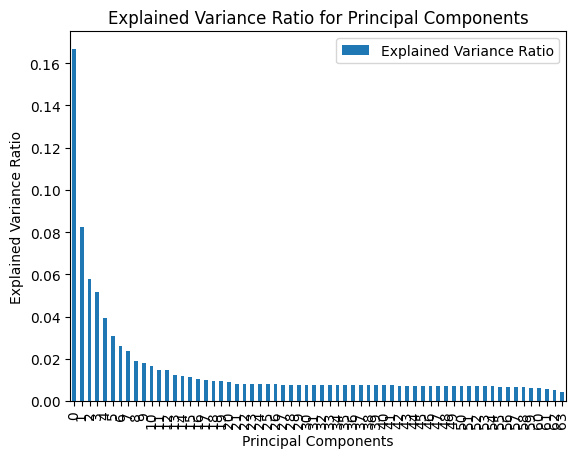

In [ ]:
# Create a DataFrame with explained variance ratio
explained_variance_df = pd.DataFrame(pca.explained_variance_ratio_, columns=['Explained Variance Ratio'])

# Plot the bar chart
explained_variance_df.plot.bar()
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Principal Components')
plt.show()

In [ ]:
X_train = X_train_pca_df
X_test = X_test_pca_df

In [ ]:
X_train

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_55,PC_56,PC_57,PC_58,PC_59,PC_60,PC_61,PC_62,PC_63,PC_64
0,6.643544,2.421798,1.119483,0.326553,-0.437334,1.173186,-3.170506,1.526227,-1.360459,1.408998,...,-0.665576,0.309677,-0.376481,0.492551,0.184629,0.559477,0.823379,-0.809680,0.307438,0.150523
1,-3.156833,-0.725192,1.306502,-1.004432,3.629137,-0.162029,-4.266584,-1.143200,0.879837,0.489074,...,0.394487,0.469534,-0.396921,-0.297008,1.416885,-0.829164,-0.198473,-0.292575,1.464041,0.843350
2,-4.763532,-1.038175,0.651978,2.162749,1.940772,1.619025,-0.787718,0.225536,0.201310,-0.879326,...,-0.333026,-0.558573,-0.396928,-0.139547,0.253596,1.028574,-0.360623,1.200347,-0.944577,0.636620
3,-4.535231,6.365716,-1.435414,0.824872,-1.116147,0.568471,-1.450874,-1.313135,-1.179943,-0.389612,...,-0.165836,0.500114,0.280380,-0.007329,-0.749932,-0.497700,0.383625,-1.205912,-0.449062,0.957447
4,3.803208,5.488896,0.919382,2.251863,3.898188,2.809207,1.366774,0.514747,-3.196481,-2.137676,...,0.534175,-0.389268,-0.464973,0.160008,1.944176,1.890023,-1.167850,-1.931632,2.407244,1.568000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98529,1.959016,0.830188,-0.951522,3.537856,-0.426066,-1.540128,-3.131382,1.705923,0.717671,-0.004540,...,1.073474,-0.647124,-0.267929,0.049905,0.911666,-0.014445,-0.650459,0.217174,-0.338317,0.062863
98530,4.667993,-0.712557,-1.268220,0.056252,-3.219899,0.520833,2.174587,-2.421775,2.794222,-2.749975,...,-2.602524,1.453234,-0.555447,0.146574,-0.246754,-0.007027,0.498523,-0.472627,0.292834,-0.358122
98531,0.254870,0.066606,-1.023380,2.294981,0.330656,0.012377,-0.265080,-0.002152,1.377946,1.313519,...,0.680328,0.483633,-0.577524,0.443175,0.512587,0.003607,-1.672425,1.053174,-0.524657,0.979720
98532,3.844974,-2.061501,-1.667856,1.561700,-1.523096,-0.550478,0.314960,-1.376635,-1.377120,0.033339,...,0.355983,-0.347549,0.333581,-0.398052,0.539688,-3.362420,0.182465,-0.311008,-0.460686,0.821318


# SMOTE
This is to handle how imbalanced the data is.

In [ ]:
def rebalancing_smote(X, y, random_seed=42):
    smote = SMOTE(random_state=random_seed)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print("Shape of X after SMOTE:", X_resampled.shape)
    print("Shape of y after SMOTE:", y_resampled.shape)
    return X_resampled, y_resampled

X_train_resampled, y_train_resampled = rebalancing_smote(X_train, y_train)

Shape of X after SMOTE: (187972, 64)
Shape of y after SMOTE: (187972,)


Count of label 1: 93986
Count of label 0: 93986


<ipython-input-27-6e78c9dd8e85>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot_split = sns.countplot(data=y_train_df, x='label', palette=colors)


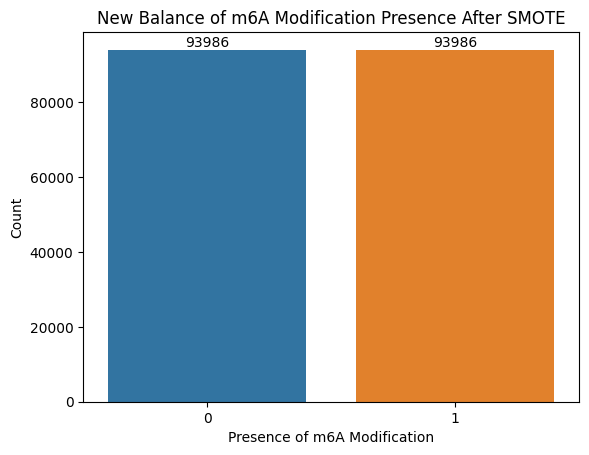

In [ ]:
# Check balance of labels
print("Count of label 1:", y_train_resampled.value_counts()[1])
print("Count of label 0:", y_train_resampled.value_counts()[0])

# Plot the balance of labels
y_train_df = pd.DataFrame(y_train_resampled, columns=['label'])

colors = ["#1f77b4", "#ff7f0e"]
bar_plot_split = sns.countplot(data=y_train_df, x='label', palette=colors)

# Annotate bar plot
for p in bar_plot_split.patches:
    bar_plot_split.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.xlabel('Presence of m6A Modification')
plt.ylabel('Count')
plt.title('New Balance of m6A Modification Presence After SMOTE')
plt.show()

# Machine Learning Models

In [ ]:
# Set random seed for reproducibility later on in hyperparameter tuning
random_seed = 42

# Initialize classifiers
classifiers = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=random_seed),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    # "Support Vector Machine": SVC(kernel='linear', probability=True, random_state=random_seed),
    "Multilayer Perceptron": MLPClassifier(random_state=random_seed),
    "AdaBoost Classifier": AdaBoostClassifier(random_state=random_seed),
    "Logistic Regression": LogisticRegression(random_state=random_seed, solver='liblinear'),
    "Stochastic Gradient Descent": SGDClassifier(random_state=random_seed),
    "Histogram-based Gradient Boosting": HistGradientBoostingClassifier(random_state=random_seed),
    "Extreme Gradient Boosting": xgb.XGBClassifier(random_state=random_seed, objective='binary:logistic'),
}

In [ ]:
# Dictionary that stores evaluation metrics of models
'''
Key: Model name
Value: A list containing the following metrics:
  - True Positive Rate
  - False Positive Rate
  - True Negative Rate
  - False Negative Rate
  - F1 Score
  - ROC AUC Score
  - PR-AUC Score
  - Recall
'''
model_results = {}

In [ ]:
# Function to view classification report
def clf_report(model_name, y_pred):
  '''
  Prints the classification report of a model.

  Inputs:
    model_name: name of the model
    y_pred: a tensor/array of n binary prediction values of shape (n, 1)
  '''
  print(model_name)

  print("Accuracy score:", round(metrics.accuracy_score(y_test, y_pred), 4))
  print("ROC AUC score:", round(metrics.roc_auc_score(y_test, y_pred), 4))
  print("F1 score:", round(metrics.f1_score(y_test, y_pred), 4))
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
  print("Precision-recall AUC score:", round(metrics.auc(recall, precision), 4))


  matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])
  tn, fp, fn, tp = matrix.ravel()
  tpr = tp / (tp + fn)
  fpr = fp / (fp + tn)
  tnr = tn / (tn + fp)
  fnr = fn / (fn + tp)
  print("TPR: {:.4f} \nFPR: {:.4f} \nTNR: {:.4f} \nFNR: {:.4f}".format(tpr, fpr, tnr, fnr))

  print(metrics.classification_report(y_test, y_pred, labels=[0, 1]))

  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=[0, 1])
  disp.plot()
  plt.show()

  model_results[model_name] = [
      tpr, fpr, tnr, fnr,
      metrics.accuracy_score(y_test, y_pred),
      metrics.precision_score(y_test, y_pred),
      metrics.f1_score(y_test, y_pred),
      metrics.roc_auc_score(y_test, y_pred),
      metrics.auc(recall, precision), # PR-AUC
      metrics.recall_score(y_test, y_pred)
  ]

KNN
Accuracy score: 0.8195
ROC AUC score: 0.7194
F1 score: 0.2121
Precision-recall AUC score: 0.3772
TPR: 0.6106 
FPR: 0.1718 
TNR: 0.8282 
FNR: 0.3894
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     22377
           1       0.13      0.61      0.21       927

    accuracy                           0.82     23304
   macro avg       0.55      0.72      0.56     23304
weighted avg       0.95      0.82      0.87     23304



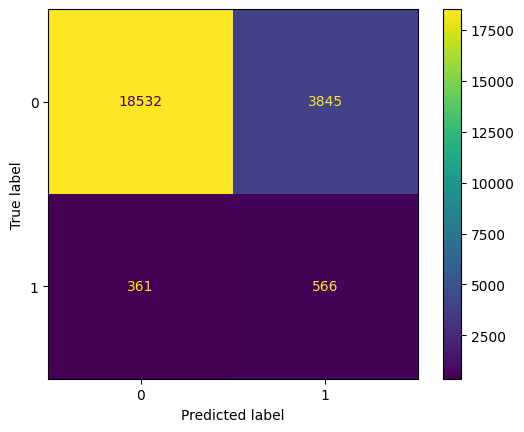


Decision Tree
Accuracy score: 0.8866
ROC AUC score: 0.6509
F1 score: 0.217
Precision-recall AUC score: 0.2842
TPR: 0.3948 
FPR: 0.0930 
TNR: 0.9070 
FNR: 0.6052
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     22377
           1       0.15      0.39      0.22       927

    accuracy                           0.89     23304
   macro avg       0.56      0.65      0.58     23304
weighted avg       0.94      0.89      0.91     23304



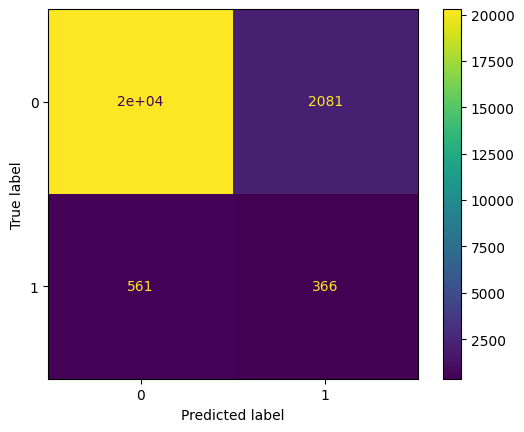


Naive Bayes
Accuracy score: 0.7432
ROC AUC score: 0.7406
F1 score: 0.186
Precision-recall AUC score: 0.4274
TPR: 0.7379 
FPR: 0.2566 
TNR: 0.7434 
FNR: 0.2621
              precision    recall  f1-score   support

           0       0.99      0.74      0.85     22377
           1       0.11      0.74      0.19       927

    accuracy                           0.74     23304
   macro avg       0.55      0.74      0.52     23304
weighted avg       0.95      0.74      0.82     23304



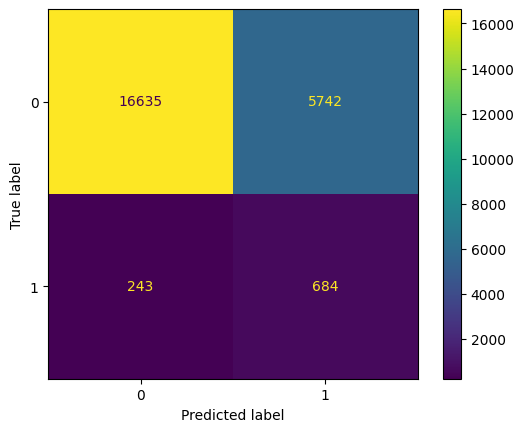


Random Forest
Accuracy score: 0.9446
ROC AUC score: 0.6599
F1 score: 0.3349
Precision-recall AUC score: 0.3485
TPR: 0.3506 
FPR: 0.0308 
TNR: 0.9692 
FNR: 0.6494
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     22377
           1       0.32      0.35      0.33       927

    accuracy                           0.94     23304
   macro avg       0.65      0.66      0.65     23304
weighted avg       0.95      0.94      0.95     23304



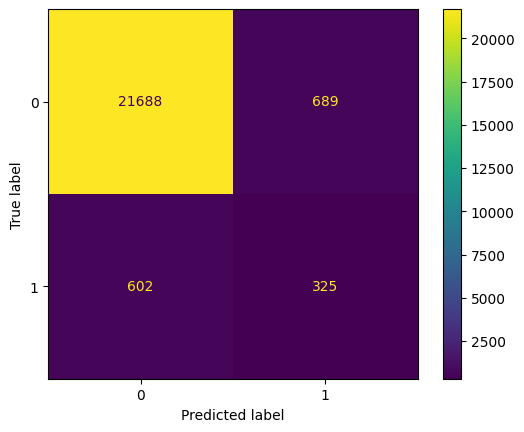


Multilayer Perceptron
Accuracy score: 0.9246
ROC AUC score: 0.7431
F1 score: 0.3655
Precision-recall AUC score: 0.4193
TPR: 0.5458 
FPR: 0.0597 
TNR: 0.9403 
FNR: 0.4542
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     22377
           1       0.27      0.55      0.37       927

    accuracy                           0.92     23304
   macro avg       0.63      0.74      0.66     23304
weighted avg       0.95      0.92      0.94     23304



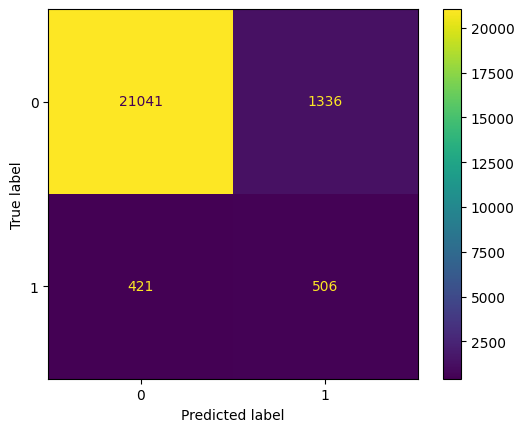

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier
Accuracy score: 0.7624
ROC AUC score: 0.7486
F1 score: 0.1972
Precision-recall AUC score: 0.429
TPR: 0.7335 
FPR: 0.2364 
TNR: 0.7636 
FNR: 0.2665
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     22377
           1       0.11      0.73      0.20       927

    accuracy                           0.76     23304
   macro avg       0.55      0.75      0.53     23304
weighted avg       0.95      0.76      0.83     23304



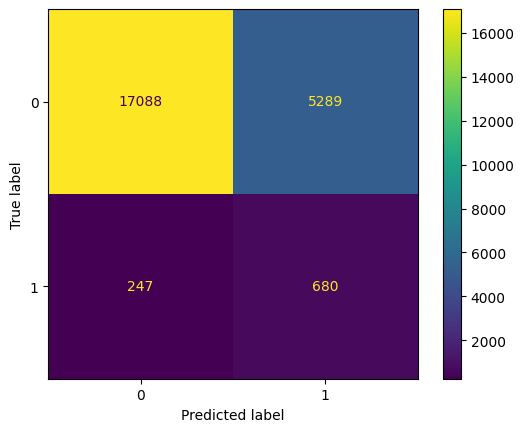


Logistic Regression
Accuracy score: 0.7467
ROC AUC score: 0.7621
F1 score: 0.1965
Precision-recall AUC score: 0.4501
TPR: 0.7789 
FPR: 0.2546 
TNR: 0.7454 
FNR: 0.2211
              precision    recall  f1-score   support

           0       0.99      0.75      0.85     22377
           1       0.11      0.78      0.20       927

    accuracy                           0.75     23304
   macro avg       0.55      0.76      0.52     23304
weighted avg       0.95      0.75      0.82     23304



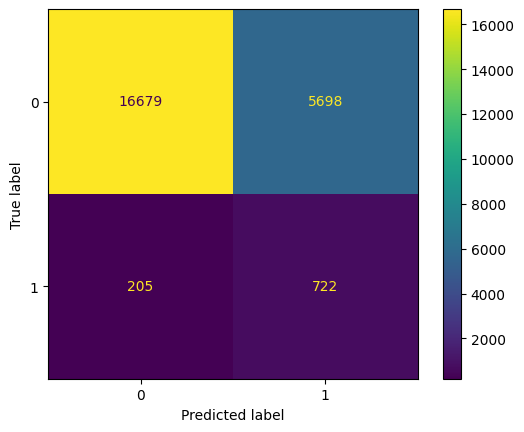


Stochastic Gradient Descent
Accuracy score: 0.7369
ROC AUC score: 0.7653
F1 score: 0.194
Precision-recall AUC score: 0.4574
TPR: 0.7961 
FPR: 0.2655 
TNR: 0.7345 
FNR: 0.2039
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     22377
           1       0.11      0.80      0.19       927

    accuracy                           0.74     23304
   macro avg       0.55      0.77      0.52     23304
weighted avg       0.95      0.74      0.82     23304



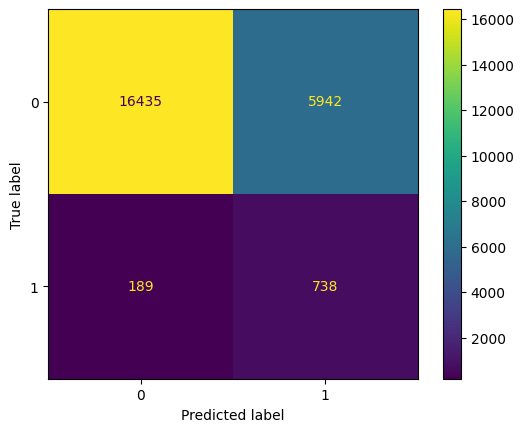


Histogram-based Gradient Boosting
Accuracy score: 0.8443
ROC AUC score: 0.7897
F1 score: 0.2717
Precision-recall AUC score: 0.454
TPR: 0.7303 
FPR: 0.1510 
TNR: 0.8490 
FNR: 0.2697
              precision    recall  f1-score   support

           0       0.99      0.85      0.91     22377
           1       0.17      0.73      0.27       927

    accuracy                           0.84     23304
   macro avg       0.58      0.79      0.59     23304
weighted avg       0.95      0.84      0.89     23304



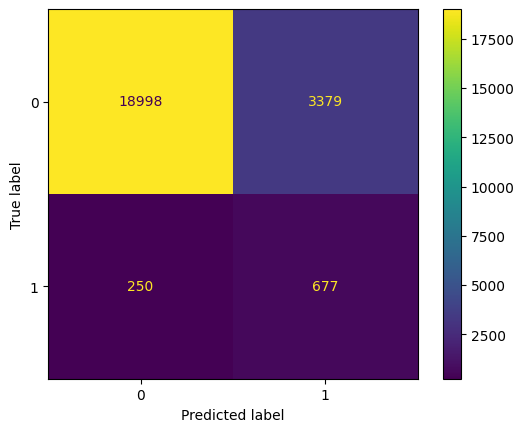


Extreme Gradient Boosting
Accuracy score: 0.8909
ROC AUC score: 0.7617
F1 score: 0.3119
Precision-recall AUC score: 0.4223
TPR: 0.6214 
FPR: 0.0979 
TNR: 0.9021 
FNR: 0.3786
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     22377
           1       0.21      0.62      0.31       927

    accuracy                           0.89     23304
   macro avg       0.60      0.76      0.63     23304
weighted avg       0.95      0.89      0.92     23304



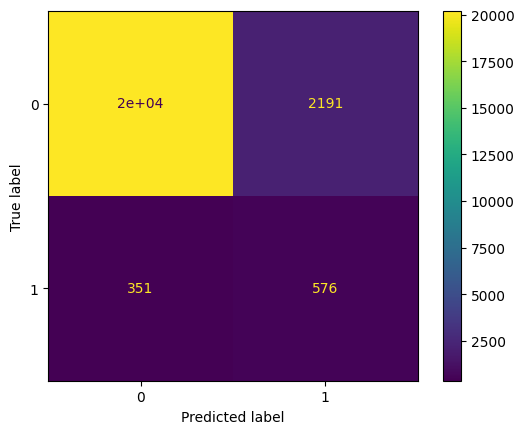

In [ ]:
# Train each model
for name, clf in classifiers.items():
    # Train the model
    clf.fit(X_train_resampled, y_train_resampled)

    # Check if the classifier supports probability prediction
    if hasattr(clf, "predict_proba"):
        # Use predicted probabilities for the positive class (class 1)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probability of class 1
        # Apply threshold of 0.5 to convert probabilities into binary predictions
        y_pred_binary = [1 if score >= 0.5 else 0 for score in y_pred_proba]
    else:
        # If predict_proba is not supported, use the regular prediction
        y_pred_binary = clf.predict(X_test)

    # Evaluate the model using the binary predictions
    clf_report(name, y_pred_binary)
    print()

    # Separator
    print(''.join(['='] * 60))
    print(''.join(['='] * 60))

In [ ]:
results_df = pd.DataFrame(model_results.values(), model_results.keys(), \
              ['TPR', 'FPR', 'TNR', 'FNR', 'Accuracy', 'Precision', 'F1 Score', 'ROC AUC Score', 'PR-AUC', 'Recall'])

results_df

,TPR,FPR,TNR,FNR,Accuracy,Precision,F1 Score,ROC AUC Score,PR-AUC,Recall
KNN,0.610572,0.171828,0.828172,0.389428,0.819516,0.128316,0.212064,0.719372,0.377189,0.610572
Decision Tree,0.394822,0.092997,0.907003,0.605178,0.886629,0.149571,0.216953,0.650912,0.284233,0.394822
Naive Bayes,0.737864,0.256603,0.743397,0.262136,0.743177,0.106443,0.186047,0.740631,0.427367,0.737864
Random Forest,0.350593,0.030791,0.969209,0.649407,0.944602,0.320513,0.334879,0.659901,0.348469,0.350593
Multilayer Perceptron,0.545847,0.059704,0.940296,0.454153,0.924605,0.274701,0.365475,0.743071,0.419307,0.545847
AdaBoost Classifier,0.733549,0.236359,0.763641,0.266451,0.762444,0.113922,0.197216,0.748595,0.429035,0.733549
Logistic Regression,0.778857,0.254636,0.745364,0.221143,0.746696,0.112461,0.196543,0.762110,0.450057,0.778857
Stochastic Gradient Descent,0.796117,0.265541,0.734459,0.203883,0.736912,0.110479,0.194032,0.765288,0.457353,0.796117
Histogram-based Gradient Boosting,0.730313,0.151003,0.848997,0.269687,0.844276,0.166913,0.271724,0.789655,0.453977,0.730313
Extreme Gradient Boosting,0.621359,0.097913,0.902087,0.378641,0.890920,0.208168,0.311857,0.761723,0.422294,0.621359


In [ ]:
# Initialize variables
best_roc_auc, best_pr_auc = 0, 0
best_roc_auc_model, best_pr_auc_model = None, None

# Iterate over model results to find the best metrics
for model, (tpr, fpr, tnr, fnr, acc, prec, f1, roc_auc, pr_auc, recall) in model_results.items():
    if roc_auc > best_roc_auc:
        best_roc_auc, best_roc_auc_model = roc_auc, model
    if pr_auc > best_pr_auc:
        best_pr_auc, best_pr_auc_model = pr_auc, model

# Print the best metrics rounded to 4 decimal places
print(f"Best PR-AUC score {best_pr_auc:.4f} achieved by {best_pr_auc_model}")
print(f"Best ROC AUC Score {best_roc_auc:.4f} achieved by {best_roc_auc_model}")


Best PR-AUC score 0.4574 achieved by Stochastic Gradient Descent
Best ROC AUC Score 0.7897 achieved by Histogram-based Gradient Boosting


In [ ]:
# Selected models
egb_model = classifiers['Extreme Gradient Boosting']
hgb_model = classifiers['Histogram-based Gradient Boosting']

In [ ]:
# Loop over each classifier and save the trained models
for name, model in classifiers.items():
    # Save the model to a file
    joblib.dump(model, f'{name}_model.joblib')
    print(f"Model {name} saved successfully.")

Model KNN saved successfully.
Model Decision Tree saved successfully.
Model Naive Bayes saved successfully.
Model Random Forest saved successfully.
Model Multilayer Perceptron saved successfully.
Model AdaBoost Classifier saved successfully.
Model Logistic Regression saved successfully.
Model Stochastic Gradient Descent saved successfully.
Model Histogram-based Gradient Boosting saved successfully.
Model Extreme Gradient Boosting saved successfully.


# Hyperparameter Tuning

## Adaboost Classifier

In [ ]:
# Set random seed for reproducibility and consistency with base models
np.random.seed(42)

# Define hyperparameter grids for AdaBoost Classifier
param_grid_ac = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1, 10],
}

grid_search_ac = GridSearchCV(AdaBoostClassifier(), param_grid_ac, cv=5, scoring='roc_auc', n_jobs= -2)
grid_search_ac.fit(X_train_resampled, y_train_resampled)

best_ac_classifier = grid_search_ac.best_estimator_

y_pred_ac = best_ac_classifier.predict(X_test)
clf_report("AdaBoost Classifier", y_pred_ac)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Best parameters for AdaBoost Classifier: {'learning_rate': 1, 'n_estimators': 200}


NameError: name 'clf_report' is not defined

Best parameters for AdaBoost Classifier: {'learning_rate': 1, 'n_estimators': 200}
AdaBoost Classifier
Accuracy score: 0.793
ROC AUC score: 0.7795
F1 score: 0.2271
Precision-recall AUC score: 0.4538
TPR: 0.7648 
FPR: 0.2059 
TNR: 0.7941 
FNR: 0.2352
              precision    recall  f1-score   support

           0       0.99      0.79      0.88     22377
           1       0.13      0.76      0.23       927

    accuracy                           0.79     23304
   macro avg       0.56      0.78      0.55     23304
weighted avg       0.95      0.79      0.85     23304



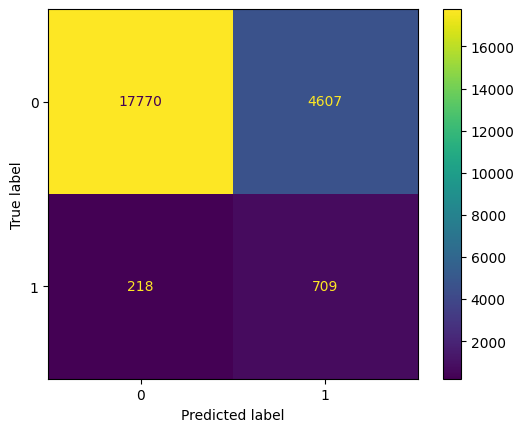

In [ ]:
print("Best parameters for AdaBoost Classifier:", grid_search_ac.best_params_)
clf_report("AdaBoost Classifier", y_pred_ac)

## Logistic Regression

Best parameters for Logistic Regression: {'C': 10, 'class_weight': 'balanced', 'max_iter': 50, 'solver': 'lbfgs', 'tol': 0.001}
Logistic Regression
Accuracy score: 0.7462
ROC AUC score: 0.7619
F1 score: 0.1962
Precision-recall AUC score: 0.45
TPR: 0.7789 
FPR: 0.2551 
TNR: 0.7449 
FNR: 0.2211
              precision    recall  f1-score   support

           0       0.99      0.74      0.85     22377
           1       0.11      0.78      0.20       927

    accuracy                           0.75     23304
   macro avg       0.55      0.76      0.52     23304
weighted avg       0.95      0.75      0.82     23304



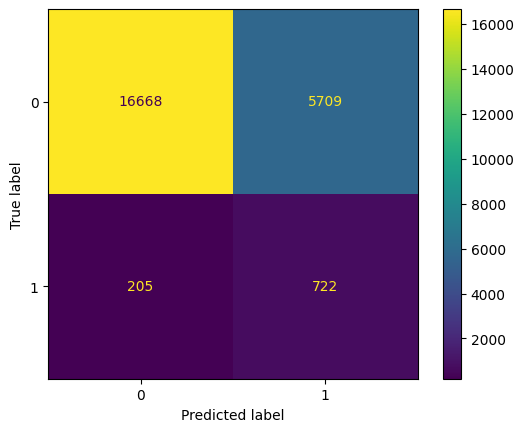

In [ ]:
# Set random seed for reproducibility and consistency with base models
np.random.seed(42)

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define hyperparameter grids for logistic regression
param_grid_lr = {
        'C': [0.01, 1, 10],                                                   # Default: 1.0
        'solver': [ 'newton-cg','lbfgs', 'sag', 'saga'],             # Default: 'lbfgs'
        'class_weight': [None, 'balanced'],                                             # Default: None
        'tol': [0.00001, 0.0001, 0.001],                                                # Default: 0.0001
        'max_iter': [50, 100, 300]                                             # Default: 100
}

grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='roc_auc', n_jobs= -2)
grid_search_lr.fit(X_train_resampled, y_train_resampled)

print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)

best_lr_classifier = grid_search_lr.best_estimator_

y_pred_lr = best_lr_classifier.predict(X_test)
clf_report("Logistic Regression", y_pred_lr)

## Stochastic Gradient Descent

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic

Best parameters for Stochastic Gradient Descent: {'alpha': 0.01, 'loss': 'log_loss', 'max_iter': 3000, 'penalty': 'l2'}
Stochastic Gradient Descent
Accuracy score: 0.7458
ROC AUC score: 0.7611
F1 score: 0.1958
Precision-recall AUC score: 0.4493
TPR: 0.7778 
FPR: 0.2555 
TNR: 0.7445 
FNR: 0.2222
              precision    recall  f1-score   support

           0       0.99      0.74      0.85     22377
           1       0.11      0.78      0.20       927

    accuracy                           0.75     23304
   macro avg       0.55      0.76      0.52     23304
weighted avg       0.95      0.75      0.82     23304



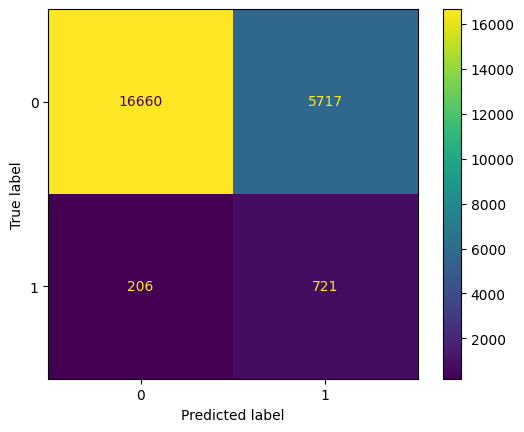

In [ ]:
# Set random seed for reproducibility and consistency with base models
np.random.seed(42)

# Define hyperparameter grids for Stochastic Gradient Descent
param_grid_sgd = {
        'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
        'penalty': ['l2', 'l1', 'elasticnet'],
        'alpha': [0.0001, 0.001, 0.01],
        'max_iter': [1000, 2000, 3000]
}

grid_search_sgd = GridSearchCV(SGDClassifier(), param_grid_sgd, cv=5, scoring='roc_auc', n_jobs= -2)
grid_search_sgd.fit(X_train_resampled, y_train_resampled)

print("Best parameters for Stochastic Gradient Descent:", grid_search_sgd.best_params_)

best_sgd_classifier = grid_search_sgd.best_estimator_

y_pred_sgd = best_sgd_classifier.predict(X_test)
clf_report("Stochastic Gradient Descent", y_pred_sgd)

## Histogram-based Gradient Boosting

Best parameters for Histogram-based Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 20, 'max_iter': 300, 'max_leaf_nodes': 127, 'min_samples_leaf': 20}
Histogram-based Gradient Boosting
Accuracy score: 0.941
ROC AUC score: 0.7097
F1 score: 0.382
Precision-recall AUC score: 0.4037
TPR: 0.4585 
FPR: 0.0390 
TNR: 0.9610 
FNR: 0.5415
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     22377
           1       0.33      0.46      0.38       927

    accuracy                           0.94     23304
   macro avg       0.65      0.71      0.68     23304
weighted avg       0.95      0.94      0.95     23304



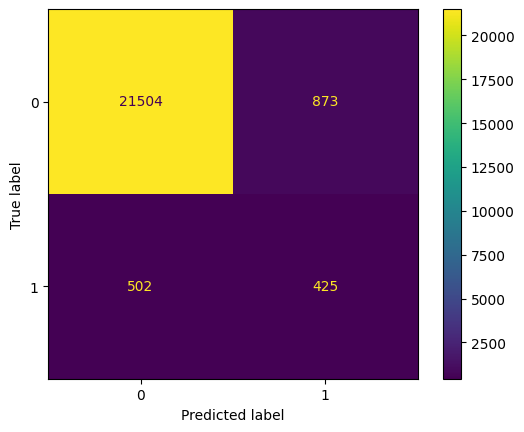

In [ ]:
# Set random seed for reproducibility and consistency with base models
np.random.seed(42)

# Define hyperparameter grids for Histogram-Based Gradient Boosting
param_grid_hgb = {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_iter': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_leaf': [20, 50, 100],
        'max_leaf_nodes': [31, 63, 127]
}

grid_search_hgb = GridSearchCV(HistGradientBoostingClassifier(random_state=random_seed), param_grid_hgb, cv=5, scoring='roc_auc', n_jobs= -2)
grid_search_hgb.fit(X_train_resampled, y_train_resampled)

print("Best parameters for Histogram-based Gradient Boosting:", grid_search_hgb.best_params_)

best_hgb_classifier = grid_search_hgb.best_estimator_

y_pred_hgb = best_hgb_classifier.predict(X_test)
clf_report("Histogram-based Gradient Boosting", y_pred_hgb)

## Extreme Gradient Boosting

Best parameters for Extreme Gradient Boosting: {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Extreme Gradient Boosting
Accuracy score: 0.9335
ROC AUC score: 0.725
F1 score: 0.3736
Precision-recall AUC score: 0.4086
TPR: 0.4984 
FPR: 0.0484 
TNR: 0.9516 
FNR: 0.5016
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     22377
           1       0.30      0.50      0.37       927

    accuracy                           0.93     23304
   macro avg       0.64      0.72      0.67     23304
weighted avg       0.95      0.93      0.94     23304



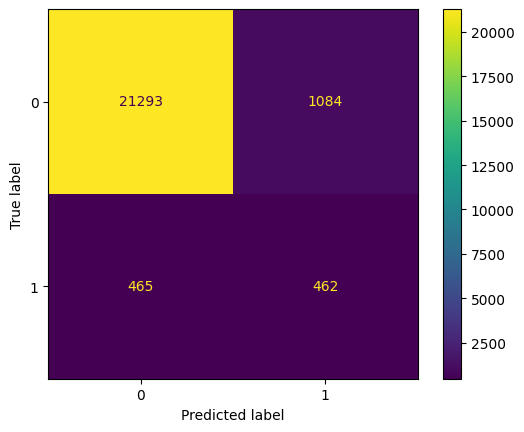

In [ ]:
# Set random seed for reproducibility and consistency with base models
np.random.seed(42)

# Define hyperparameter grids for Extreme Gradient Boosting
param_grid_egb = {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1]
}

grid_search_egb = GridSearchCV(xgb.XGBClassifier(random_state=random_seed, objective='binary:logistic'), param_grid_egb, cv=5, scoring='roc_auc', n_jobs= -2)
grid_search_egb.fit(X_train_resampled, y_train_resampled)

print("Best parameters for Extreme Gradient Boosting:", grid_search_egb.best_params_)

best_egb_classifier = grid_search_egb.best_estimator_

y_pred_egb = best_egb_classifier.predict(X_test)
clf_report("Extreme Gradient Boosting", y_pred_egb)